In [25]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import wdtools
import matplotlib.gridspec as gridspec
sp = wdtools.SpecTools()
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58

import pyphot
from pyphot import unit
plt.rcParams.update({'font.size': 18})

plt.style.use('vedant')

In [26]:
lib = pyphot.get_library()
mean_wls = np.asarray([3596, 4639, 6122,7439,8896])
lamgrid = np.linspace(3100, 9900, 6000)
abs_distance = 10 # pc

## MPMS

In [27]:
import isochrones.mist
mist = isochrones.mist.MIST_Isochrone(bands = ['SDSS_u', 'SDSS_g', 'SDSS_r'])

In [28]:
sys.path.append('../../')
import read_mist_models

In [29]:
old_iso = read_mist_models.ISOCMD('../../mpms_mist.cmd')

Reading in: ../../mpms_mist.cmd


## WD

In [30]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

In [31]:
interpwd = pickle.load(open('interp/interpwd.p', 'rb'))
def get_wd(teff, logg, wl):
    return 10**interpwd((logg, teff, np.log10(wl)))

In [1]:
abs_distance = 10
def get_cal_spec_wd(teff, logg):
    
    mfl = get_wd(teff, logg, lamgrid)

    radius = logg_teff_to_rsun(logg, teff) * radius_sun
    distance = abs_distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl            #### ADD GP or EXTINCTION?
    mfl = 2.99e21 * (mfl/1000) * (1 /lamgrid**2)
    
    return mfl 

def get_sdss_sed_wd(teff, logg, to_mag = False):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z']:
        f = lib['SDSS_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

# Color-Color

In [34]:
teffs = np.linspace(4000, 10000, 100)
wd_seds = np.asarray([get_sdss_sed_wd(teff, 8, True) for teff in teffs])
wd_seds_7 = np.asarray([get_sdss_sed_wd(teff, 7, True) for teff in teffs])
wd_seds_9 = np.asarray([get_sdss_sed_wd(teff, 9, True) for teff in teffs])

# mpms_seds = np.asarray([get_sdss_sed_mpms(teff, 4.5, True) for teff in teffs])
# mpms_seds_3 = np.asarray([get_sdss_sed_mpms(teff, 3, True) for teff in teffs])
# mpms_seds_6 = np.asarray([get_sdss_sed_mpms(teff, 6, True) for teff in teffs])

In [35]:
wd_ug = wd_seds[:, 0] - wd_seds[:, 1]
# mpms_ug = mpms_seds[:, 0] - mpms_seds[:, 1]
wd_7_ug = wd_seds_7[:, 0] - wd_seds_7[:, 1]
# mpms_3_ug = mpms_seds_3[:, 0] - mpms_seds_3[:, 1]
wd_9_ug = wd_seds_9[:, 0] - wd_seds_9[:, 1]
# mpms_6_ug = mpms_seds_6[:, 0] - mpms_seds_6[:, 1]

In [36]:
wd_gr = wd_seds[:, 1] - wd_seds[:, 2]
# mpms_gr = mpms_seds[:, 1] - mpms_seds[:, 2]
wd_7_gr = wd_seds_7[:, 1] - wd_seds_7[:, 2]
# mpms_3_gr = mpms_seds_3[:, 1] - mpms_seds_3[:, 2]
wd_9_gr = wd_seds_9[:, 1] - wd_seds_9[:, 2]
# mpms_6_gr = mpms_seds_6[:, 1] - mpms_seds_6[:, 2]

## Overlay SDSS

In [37]:
table = Table.read('tables/lr_class.fits')
table['g-r'] = table['g_0'] - table['r_0']
table['u-g'] = table['u_0'] - table['g_0']

In [38]:
clean = (
    (table['g-r'] != 0)*
    (table['g-r'] > -0.25)*
    (table['g-r'] < 2)*
    (table['u-g'] < 2)*
    (table['u-g'] > 0)
)

mpms = table['ty'] == 'sdA/F'
da = table['ty'] == 'DA'

In [39]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [42]:
cids = [3890626773968983296]
candidates = [find_nearest(table['source_id'], id) for id in cids]

In [53]:
%matplotlib inline

10.0


Text(0.5, 0, 'Effective Temperature (K)')

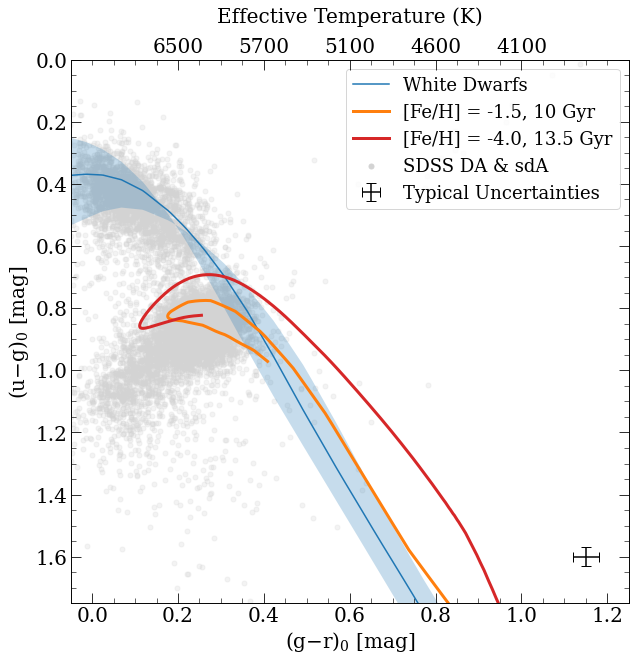

In [54]:
plt.rcParams.update({'font.size': 20})


plt.figure(figsize = (10, 10))

plt.scatter(table[clean*mpms]['g-r'], table[clean*mpms]['u-g'], 
            color = 'lightgrey', s = 25, alpha = 0.25, label = 'SDSS DA & sdA', rasterized = True)
plt.scatter(table[clean*da]['g-r'], table[clean*da]['u-g'], rasterized = True, 
            color = 'lightgrey', s = 25, alpha = 0.25)
# plt.scatter(table[candidates]['g-r'], table[candidates]['u-g'], s = 75, alpha = 1, 
#            label = 'Caffau\'s Star', marker = '*', color = 'r')

args = dict(color = 'C0')
plt.plot(wd_gr, wd_ug, **args, linestyle = '-', label = 'White Dwarfs', linewidth = 1.5)
# plt.plot(wd_7_gr, wd_7_ug, **args, linestyle = '--', linewidth = 1)
# plt.plot(wd_9_gr, wd_9_ug, **args, linestyle = '--', linewidth = 2)
plt.fill_between(wd_gr, wd_7_ug, wd_9_ug, alpha = 0.25)

args = dict(color = 'C1')
age_gyr = 10
log_age = np.log10(age_gyr * 1e9)
print(log_age)
iso = mist.isochrone(log_age, -1.5)
mask = (iso['eep'] > 202) & (iso['eep'] < 605) & (iso['logg'] > 3.5)
mpms_ug = np.asarray(iso['SDSS_u_mag'] - iso['SDSS_g_mag'])[mask]
mpms_gr = np.asarray(iso['SDSS_g_mag'] - iso['SDSS_r_mag'])[mask]
plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -1.5, 10 Gyr', linewidth = 3)

args = dict(color = 'C3')
mask = (old_iso.isocmds[0]['log_g'] > 3.5)
mpms_ug = np.asarray(old_iso.isocmds[0]['SDSS_u'] - old_iso.isocmds[0]['SDSS_g'])[mask]
mpms_gr = np.asarray(old_iso.isocmds[0]['SDSS_g'] - old_iso.isocmds[0]['SDSS_r'])[mask]
plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -4.0, 13.5 Gyr', linewidth = 3)

# age_gyr = 13.5
# log_age = np.log10(age_gyr * 1e9)
# print(log_age)
# iso = mist.isochrone(log_age, -3.5)
# mask = (iso['eep'] > 202) & (iso['eep'] < 605) & (iso['logg'] > 3.9)
# mpms_ug = np.asarray(iso['SDSS_u_mag'] - iso['SDSS_g_mag'])[mask]
# mpms_gr = np.asarray(iso['SDSS_g_mag'] - iso['SDSS_r_mag'])[mask]
# plt.plot(mpms_gr, mpms_ug, **args, label = '[Fe/H] = -3.5, 13.5 Gyr', linewidth = 1.5)

plt.errorbar(1.15,1.6, yerr = 0.03, xerr = 0.03, color = 'black', ecolor = 'k', capsize = 5,
            label = 'Typical Uncertainties', linestyle = 'none')

leg = plt.legend(fontsize = 18, loc=1)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.xlabel('(g$-$r)$_0$ [mag]')
plt.ylabel('(u$-$g)$_0$ [mag]')
plt.gca().invert_yaxis()

plt.xlim(-0.05, 1.25)
plt.ylim(1.75, 0)

c1 = 2.5
c2 = -0.4
grgrid = np.linspace(0, 1, 100)
#plt.plot(grgrid, c1 * grgrid + c2)


ticklocs = [0.2, 0.4, 0.6, 0.8, 1]
ax = plt.gca()
axtop = ax.twiny()

tickfunc = interp1d(mpms_gr, 10**old_iso.isocmds[0]['log_Teff'][mask])
axtop.set_xlim(ax.get_xlim())
axtop.set_xticks(ticklocs)
axtop.set_xticklabels(np.round(tickfunc(ticklocs), -2).astype(int))
axtop.set_xlabel('Effective Temperature (K)' , labelpad = 15)

#plt.savefig('fig/theory_color_color.pdf', bbox_inches = 'tight', rasterized = True, dpi = 300)

In [55]:
cleantable = table[clean*mpms]

In [60]:
def get_spectrum(source_id):
    path = '../../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

In [64]:
sel = (
    (cleantable['g-r'] > 0.5)*
    (cleantable['g-r'] < 0.8)*
    (cleantable['u-g'] > 0.9)*
    (cleantable['u-g'] < 1.2)
)

sum(sel)

10

In [67]:
def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

def rv_corr(wl, fl):
    obs_alpha,_,_, _, _ = sp.find_centroid(wl, fl, halpha, make_plot = False, n_fit = 2, 
                            half_window = 50, debug = False, window_step = 5)

    vr = - 1e-3 * speed_light * (obs_alpha - halpha)/halpha

    fl, shift_wl = pyasl.dopplerShift(wl, fl, vr, edgeHandling = 'fillValue', fillValue = 1)
    return wl, fl

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def plot_metals(wl, fl, source = '', teff = 6000, logg = 4.5, alpha = 0):
        
    f = plt.figure(figsize = (10, 15))
    gs = f.add_gridspec(4, 2)
    
    ax1 = f.add_subplot(gs[0, :])
    
    
    idx = bisect_left(wl, 5865)
    plt.plot(wl, fl / fl[idx])
    plt.title(source)
    #plt.title(str(obj['source_id'][0]) + ' (%i, %.1f)'%(teff, logg))
    
    ax2 = f.add_subplot(gs[1, 0])
    
    cwl, cfl = cont_norm(wl, fl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    #plt.xlim(3925, 3940)
    #plt.axvline(ca2k, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.title('Ca II K')
    plt.ylim(0.5, 1.3)
    
    
    ax3 = f.add_subplot(gs[1,1])

    
    cwl, cfl = cont_norm(wl, fl, na2, 75, 15)
    plt.plot(cwl, cfl)
    plt.plot(cwl, cfl)
#     plt.axvline(na1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(na2, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Na')
    
    ax4 = f.add_subplot(gs[2,0])
    
    cwl, cfl = cont_norm(wl, fl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    plt.xlim(ca1-25, ca3+25)
#     plt.axvline(ca1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca2, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca3, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Ca Triplet')
    
    ax5 = f.add_subplot(gs[2,1])
    
    cwl, cfl = cont_norm(wl, fl, ch, 26, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('CH G-Band')
    
    ax6 = f.add_subplot(gs[3,0])
    
    cwl, cfl = cont_norm(wl, fl, 4334, 50, 10)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('H-Gamma')
    
    ax6 = f.add_subplot(gs[3,1])
    
    cwl, cfl = cont_norm(wl, fl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    #plt.axvline(hbeta, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.1, 1.3)
    plt.title('H-Beta')
    
    
    
    plt.tight_layout()
    
    return ax1
#     plt.savefig('mp_stars/' + str(source) + '.png', bbox_inches = 'tight')


na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52

ca2k = 3934.777

ch = 4302

21.059


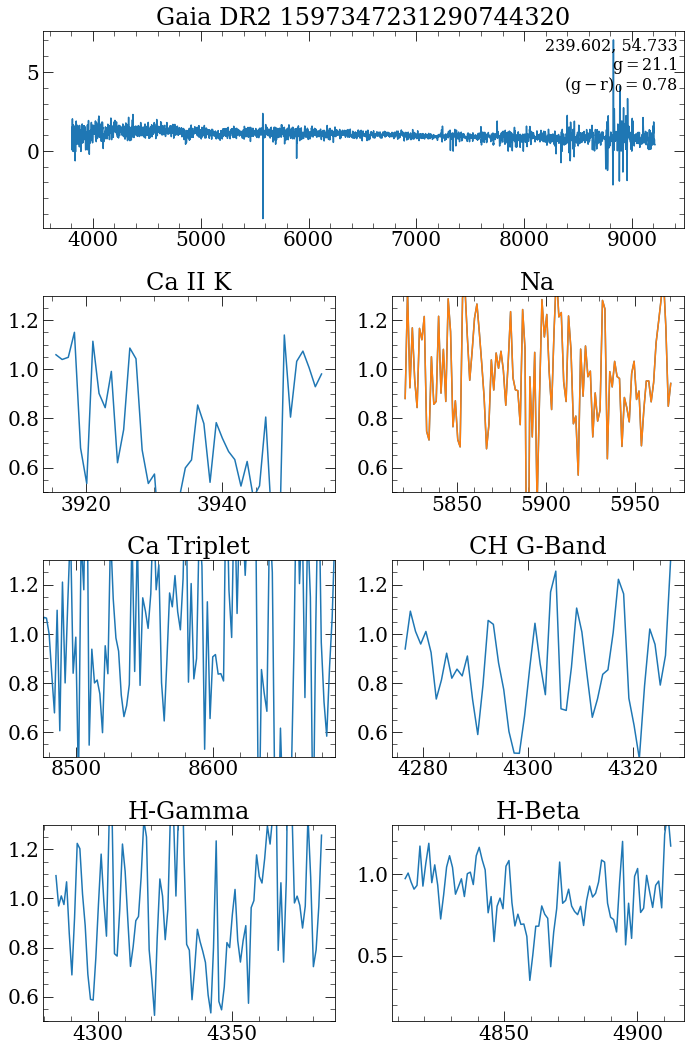

17.802


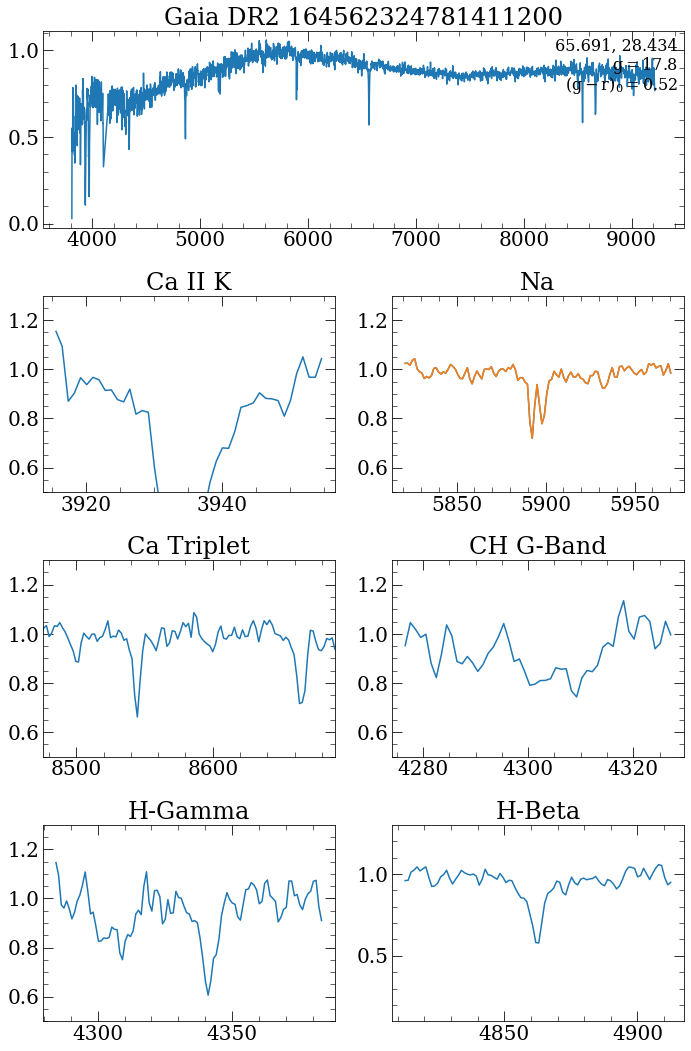

18.269000000000002


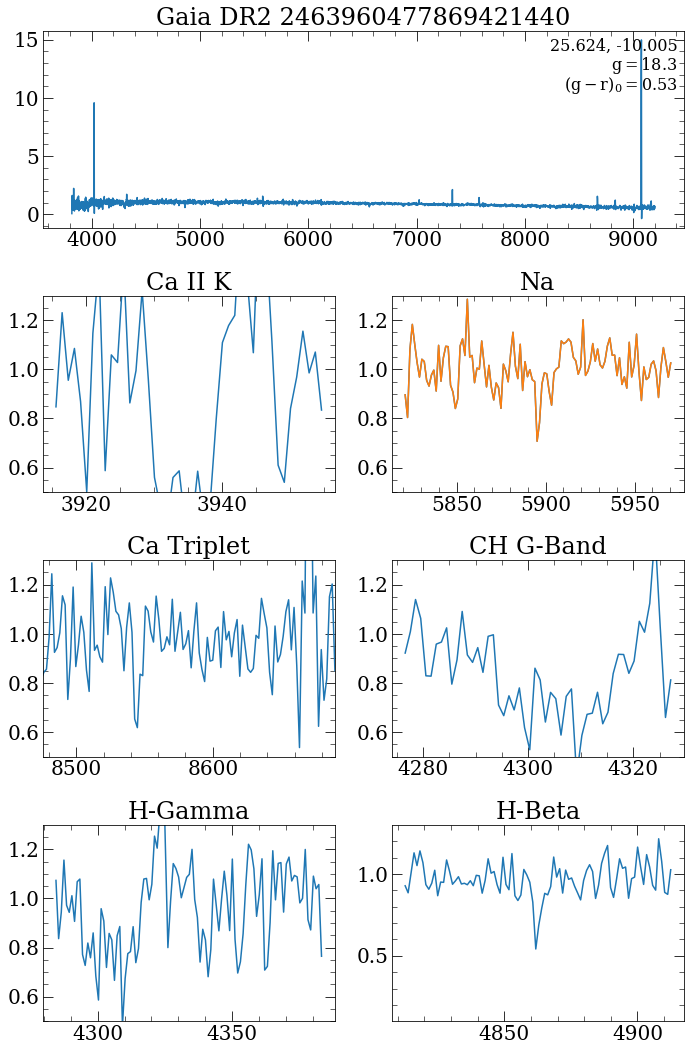

20.381


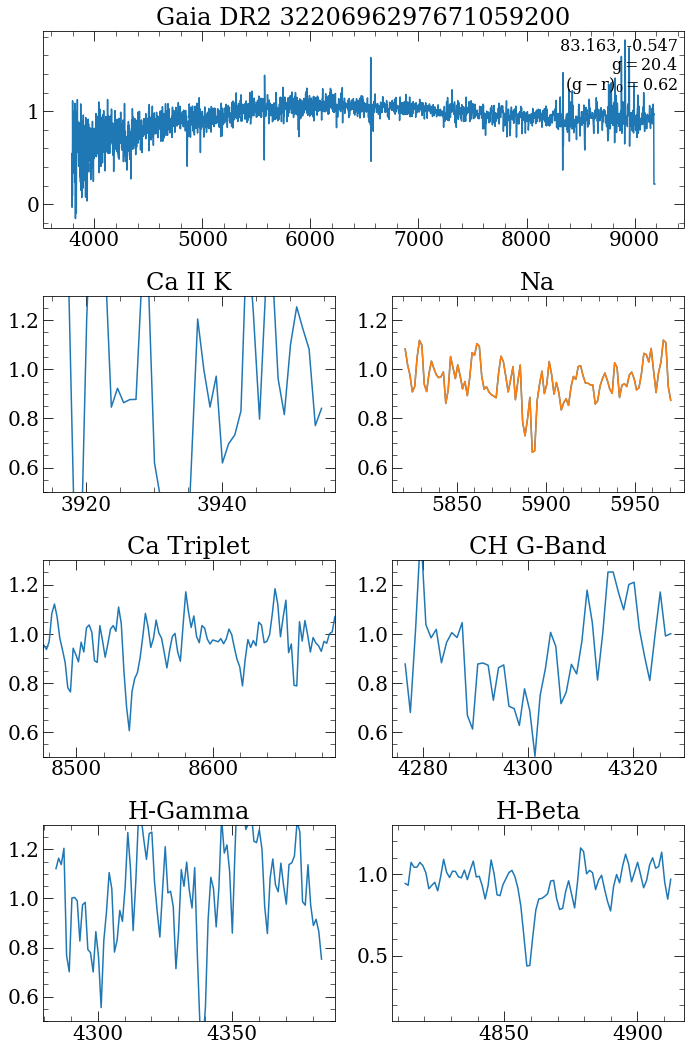

16.99


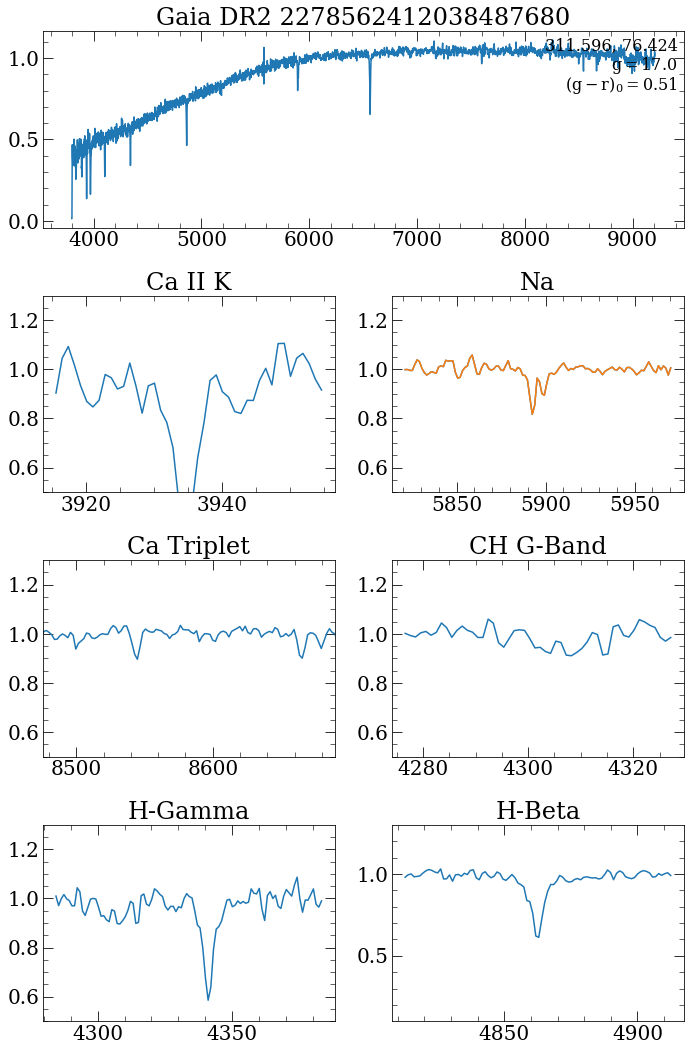

20.074


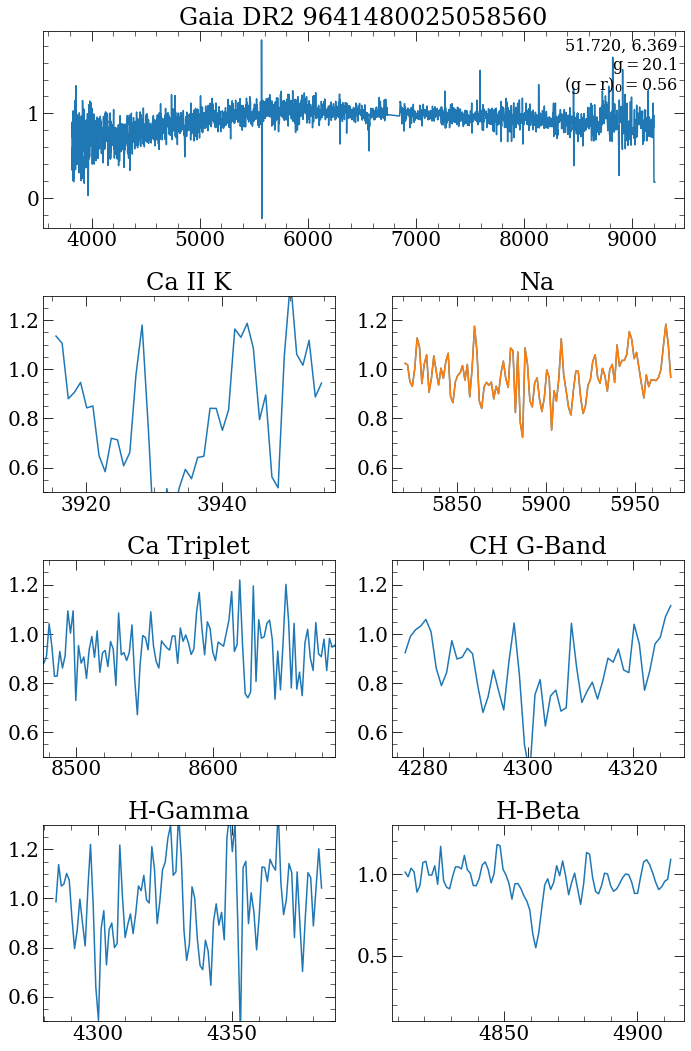

19.62


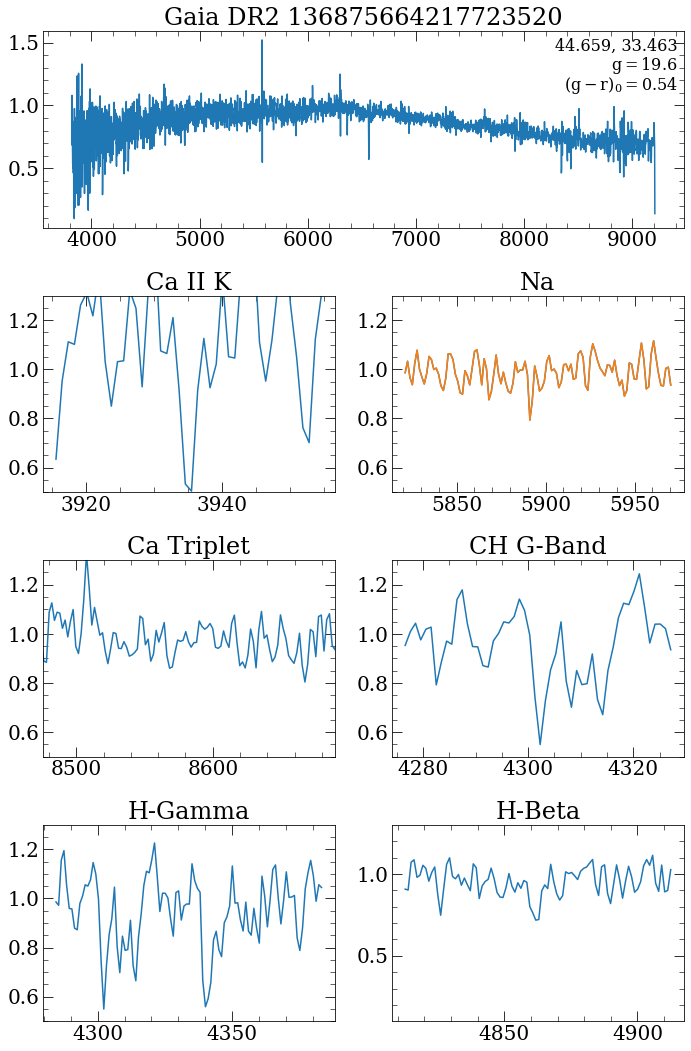

17.947


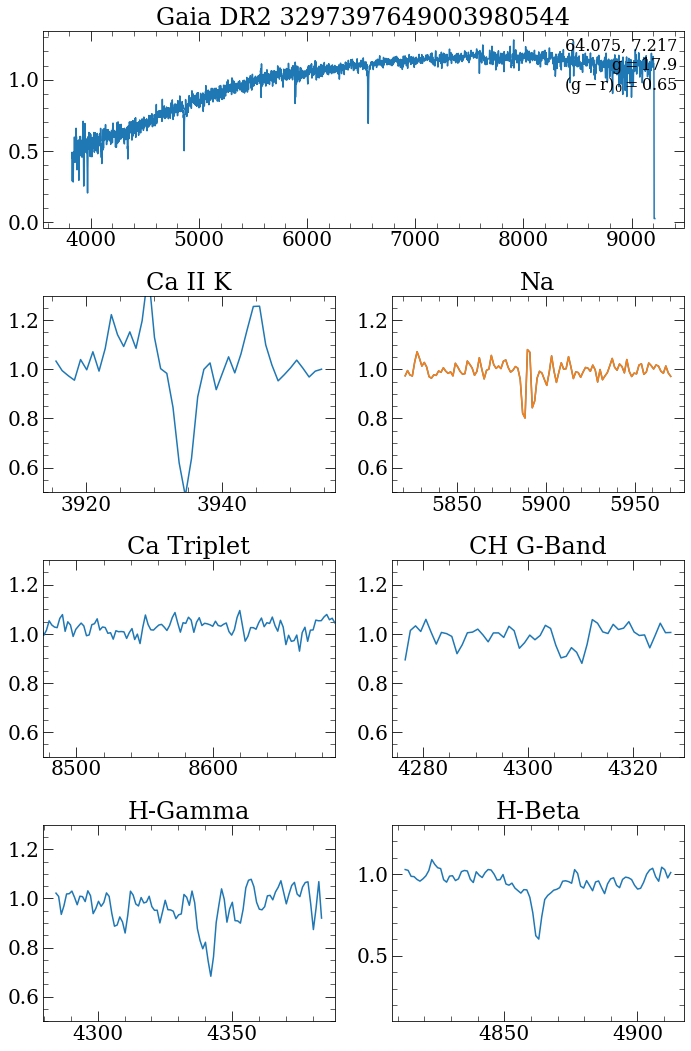

19.067


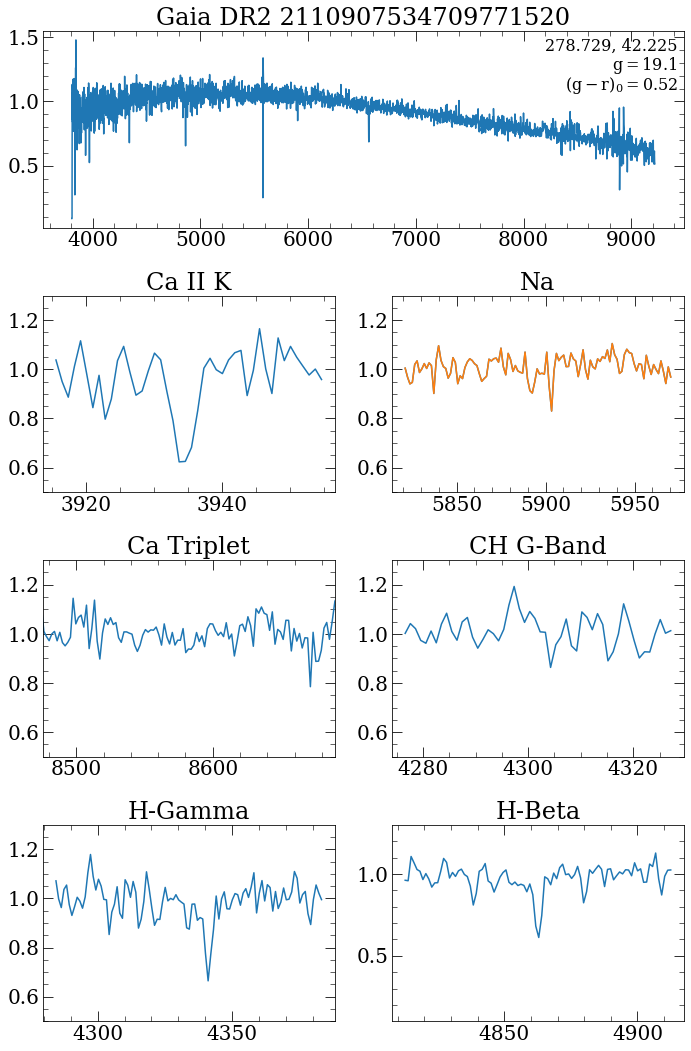

18.504


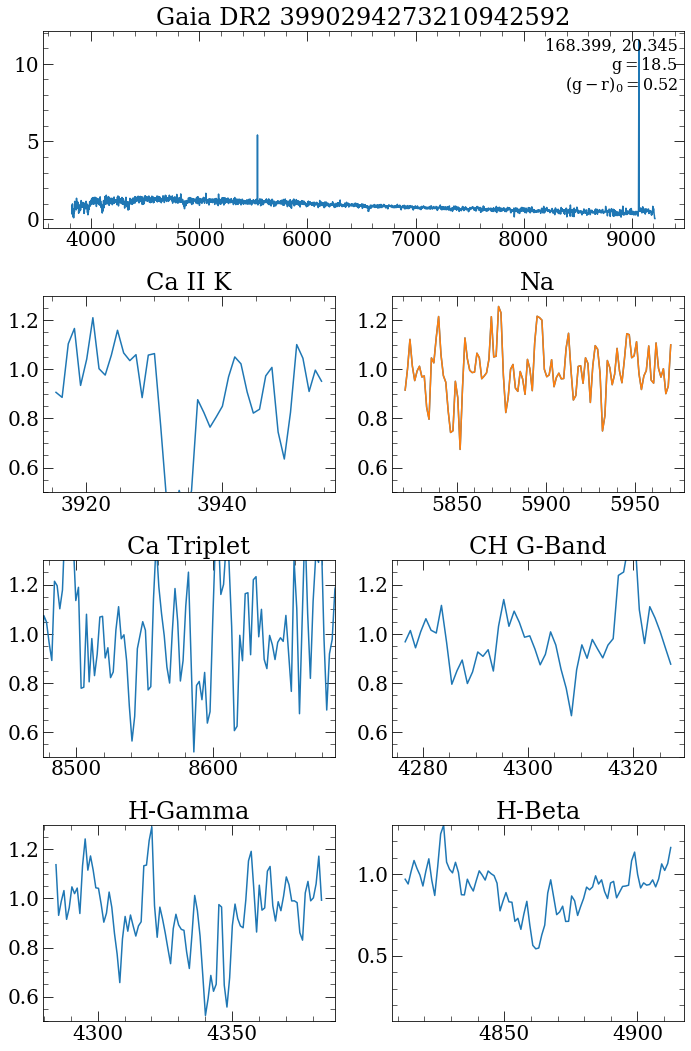

In [68]:
for obj in cleantable[sel]:
    wl, fl = get_spectrum(obj['source_id'])
    wl,fl = rv_corr(wl, fl)
    
    ax = plot_metals(wl, fl, teff = 6500, logg = 4.5, alpha = 0, source = 'Gaia DR2 ' + str(obj['source_id']))
    ax.text(0.99, 0.9, '%.3f, %.3f' % (obj['ra'], obj['dec']), transform = ax.transAxes, fontsize = 16,
           ha = 'right')
    ax.text(0.99, 0.8, '$g = %.1f$' % obj['g'], transform = ax.transAxes, fontsize = 16, ha = 'right')
    ax.text(0.99, 0.7, '$(g-r)_0 = %.2f$' % obj['g-r_0'], transform = ax.transAxes, fontsize = 16, ha = 'right')
    
    print(obj['g'])
    plt.show()